# Style Transfer using VGG19

Style transfer (https://arxiv.org/abs/1508.06576) allows to apply the style underlying an image to another input image. The idea is to load 2 images: i) a content image and ii) a style image and mix them so that the content image is processed to look like the style image. 

For the purpose, the VGG19 CNN previously trained for image classification can be used as a feature extractor to separate the style of an image from its content and viceversa, and consequently extract the content from one and the style of a different one and mix them together. In a CNN the convolution layers learn progressively complex features while the maxpooling layers break the spatial relationship between those features. So deeper layer are more concerned with the actual content of an image, rather than size, rotation, color variation, etc. On the opposite, we need features capturing texture and other aspects typical of the style which are normally detected in the initial layers of the network. So by ingesting in the VGG19 the content image and the style image we can respectively extract the content representation from the final convolutional layers (in the paper from the 4th convolution block) and the style representation from the initial convolutional layers. For the latter we aim at finding style similarities by checking the correlation (see Gram Matrix) between different convolution layers in all blocks, which have different sizes (given the presence of maxpooling layers) and consequently allow for the extraction of some sort of multi-scale style representation.

This way an input image can be compared firstly to refer to the content image and then to the style image.
This is achieved by computing 2 difference distance or loss functions: i) a L_<sub>content</sub> describing the difference in terms of content and ii) a L_<sub>style</sub> indicating the style difference between the images. The loss function can be a simple mean squared error (MSE) between the reference and input representation (i.e., their Gram Matrix). A heuristic function, i.e. a coefficient $\alpha$ and $\beta$ respectively for content and style, can be used to weight the amount of style to be applied, i.e., to adjust the share accounted by each of those losses while doing backpropagation to generate a target image. We normally talk of $\alpha/\beta$ ratio.

![VGG19](https://cdn-images-1.medium.com/max/1600/1*-lIw_z6HEPHaGSpSOhyBow.png "VGG19")

**P.S.:** The Gram Matrix is computed by flattening the input feature matrix (image) into a vector. This way a 3D convolutional layer can be converted to a matrix, which can then be multiplied to its transpose. Multiplying the feature matrix to its transpose generates the so-called Gram Matrix. Matrix multiplication treats each value as unrelated of neighbouring values which means that the resulting Gram Matrix will contain location-unrelated (i.e., the latent texture represented in the layer is insensitive to location differences) information for the layer.

In [1]:
%matplotlib inline

import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
import os

from matplotlib import pyplot
from matplotlib.pyplot import imshow

Using TensorFlow backend.


## Limit GPU Resource Usage

In [2]:
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
# use only half of available GPU RAM
config.gpu_options.per_process_gpu_memory_fraction = 0.7
set_session(tf.Session(config=config))

## Load the VGG 19 Model for Image Classification

In [3]:
from keras.applications import vgg19
#https://keras.io/applications/#vgg19
vgg19_model = keras.applications.vgg19.VGG19(include_top=False,
                                             weights='imagenet',
                                             input_tensor=None,
                                             input_shape=(224, 224, 3),
                                             pooling=None,
                                             classes=1000)
vgg19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

We want to use Vgg19 as feature extractor, so training should be disabled:

In [4]:
for layer in vgg19_model.layers:
    layer.trainable = False

In [5]:
vgg19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [6]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator

def load_image_1(path, shape=None):
    img = load_img( path )
    if shape is not None:
        img = img.resize((shape[0], shape[1]))
    return img_to_array( img )

from skimage.io import imread
from skimage.transform import resize

def load_image_2(path, shape=None):
    img = imread(path)
    if shape is not None:
        img = resize(img, shape)
    return img_to_array(img)

from PIL import Image
def load_image_3(path, shape=None):
    img = Image.open(path)
    if shape is not None:
        img = img.resize((shape[0], shape[1]))
    return img_to_array(img)

In [7]:
w = 224
h = 224

In [8]:
!ls data/style_transfer

Gubbio.jpg  Tsunami_by_hokusai_19th_century.jpg


### Load the Style Image

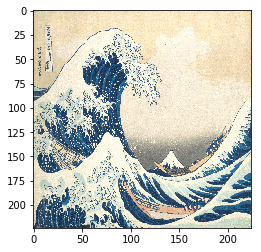

In [10]:
style_img = load_image_1("data/style_transfer/Tsunami_by_hokusai_19th_century.jpg", shape=(w,h))
style_img = style_img.astype('uint8')
pyplot.imshow(style_img)

### Load the Content Image

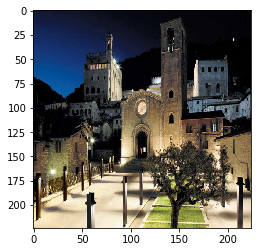

In [11]:
content_img = load_image_1("data/style_transfer/Gubbio.jpg", shape=(w,h))
content_img = content_img.astype("uint8")
pyplot.imshow(content_img)

Apparently, VGG networks were trained on images represented as BGR instead of RGB and that were initially normalized on the mean color, i.e., BGR_mean = [103.939, 116.779, 123.68]. Keras provides a preprocess_input method to adapt our pictures to the VGG input format.

In [12]:
def adapt_to_vgg19(img):
    print "source image", img.shape
    # add batch dimension
    img = np.expand_dims(img, axis=0)
    print "adapted image", img.shape
    return keras.applications.vgg19.preprocess_input(img)

We can similarly define the opposite function:

In [13]:
def adapt_from_vgg19(img):
    print "vgg19 format", img.shape
    img = np.squeeze(img, axis=0)
    print "adapted to", img.shape
    # remove the normalization from the normalized output
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # reverse to RGB from BGR
    img = img[:, :, ::-1]
    return img.astype("uint8")

Let's do an example conversion to and from VGG19 format:

In [14]:
ci_vgg19 = adapt_to_vgg19(content_img)
print "ci_vgg19.shape", ci_vgg19.shape

source image (224, 224, 3)
adapted image (1, 224, 224, 3)
ci_vgg19.shape (1, 224, 224, 3)


vgg19 format (1, 224, 224, 3)
adapted to (224, 224, 3)
ci.shape (224, 224, 3)


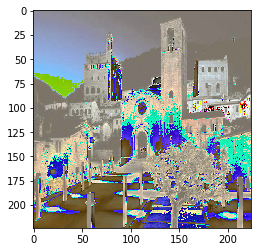

In [17]:
ci = adapt_from_vgg19(ci_vgg19)
print "ci.shape", ci.shape
pyplot.imshow(ci)

In [18]:
content_image = adapt_to_vgg19(content_img)
style_image = adapt_to_vgg19(style_img)

source image (224, 224, 3)
adapted image (1, 224, 224, 3)
source image (224, 224, 3)
adapted image (1, 224, 224, 3)


### Extracting content and style representations of the images

Based on the original paper, let's start by defining the layers to use for the content representation and those for the style representation:

In [19]:
# content representation is on output of layer conv4_2
content_layers = [
    "block4_conv2"
    #'block5_conv2'
    ] 

In [20]:
# style representation is on layers:
# conv1_1, conv2_1, conv3_1, conv4_1, conv5_1
style_layers = ["block1_conv1",
                "block2_conv1",
                "block3_conv1", 
                "block4_conv1", 
                "block5_conv1"]

### Defining the Loss Functions

In [21]:
# pass the content image and the input image
# compute mse over content layer of the 2 different feedforward passes
def mse(true, predicted):
    # calculate mse for tensors, using Keras' tensor operations
    return K.mean(K.square(predicted - true))

def se(true, predicted):
    return K.sum(K.square(predicted - true))

def content_loss(content_representation, input_representation):
    return se(content_representation, input_representation)

In [25]:
# pass the style image and the input image
# compute the loss as distance between gram matrices
def gram_matrix(tensor):
    # reshape to have the channel at the beginning
    # i.e. (224,224,3) -> (3,224,224)
    if K.image_data_format() == "channels_last":
        # reorder with channel first, leave the rest untouched
        tensor = K.permute_dimensions(tensor, (2, 0, 1))
    flattened_tensor = K.batch_flatten(tensor)
    # a gram matrix is a flattened layer tensor multiplied to its transpose
    return K.dot(flattened_tensor, K.transpose(flattened_tensor))

# the layer contribution depends on the number of channels and the image size
size = w*h
channels = 3
layer_contribution = (4.0 * (channels ** 2) * (size ** 2))

def style_layer_loss(target_style_representation, input_representation):
    # compare the gram matrices of the target style and input representation
    target_style_gram = gram_matrix(target_style_representation)
    gram_input = gram_matrix(input_representation)
    return se(target_style_gram, gram_input) / layer_contribution

In [87]:
print content_image.shape
def compute_loss(content_image, style_image, h_weight_content=0.5, h_weight_style=0.5):
    # transform content image to tensor
    content_tensor = K.variable(content_image)
    
    # transform image to tensor
    style_tensor = K.variable(style_image)
    
    # create empty tensor for the input image - (1, 224, 224, 3)
    input_image = K.placeholder((1, h, w, 3)) #K.placeholder(content_image.shape)

    # create a batch of input images:
    input_tensors = K.concatenate([content_tensor, # position 0
                                   style_tensor,   # position 1
                                   input_image],   # position 2
                                  axis=0)
    
    # Extract context and style representation by passing the images in the VGG19 network with a feedforward pass
    loss = K.variable(0.0)
    # **** compute content loss ****
    for layer in content_layers:
        print vgg19_model.get_layer(layer).output
        # get tensor for the content image
        # content_representation = vgg19_model.get_layer("block4_conv2").output[0]
        content_representation = vgg19_model.get_layer(layer).output[0]
        print "content_representation.shape", content_representation.shape

        # get tensor for the input image
        # input_img_representation = vgg19_model.get_layer("block4_conv2").output[2]
        input_img_representation = vgg19_model.get_layer(layer).output[2]
        print "input_img_representation.shape", input_img_representation.shape

        # compute loss for the layer being visited
        # the loss is equally divided for each layer accounting to the content loss
        # the loss is weighted to the heuristic weight for the content
        loss += h_weight_content * (1/len(content_layers)) * content_loss(content_representation, input_img_representation)
    # **** compute content loss ****
    
    # **** compute style loss ****
    for layer in style_layers:
        style_representation = vgg19_model.get_layer(layer).output[1]
        print "style_representation.shape", style_representation.shape
        input_img_representation = vgg19_model.get_layer(layer).output[2]
        print "input_img_representation.shape", input_img_representation.shape
        # the style loss is the weighted sum of the loss of all style layers
        # the weight is calculated so that the 5 style layers have each 1/5 weight and all others 0
        # also, since we use a heuristic to define the weight of style wrt content we also multiply to that
        loss += h_weight_style * (1/len(style_layers)) * style_layer_loss(style_representation, input_img_representation)
    # **** compute style loss ****
    
    # calculate loss gradients wrt the currently used input image
    grads = K.gradients(loss, input_image)
    
    outputs = [loss]
    print "outputs", outputs
    if isinstance(grads, (list, tuple)): 
        outputs += grads
    else:
        outputs.append(grads)
    
    print "outputs", outputs
    keras_fun = K.function([input_image], outputs)

    return keras_fun

(1, 224, 224, 3)


In [88]:
from scipy.optimize import fmin_l_bfgs_b


def eval_loss_and_grads(keras_fun, x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, h, w))
    else:
        x = x.reshape((1, h, w, 3))
    outs = keras_fun([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self, keras_fun):
        self.loss_value = None
        self.grads_values = None
        self.keras_fun = keras_fun

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(keras_fun, x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
    

def iterate_over_loss_optimization(content_img,
                                   style_img,
                                   h_weight_content = 0.5,
                                   h_weight_style = 0.5,
                                   iterations=10):
    # open input images
    content_image = adapt_to_vgg19(content_img)
    style_image = adapt_to_vgg19(style_img)

    # Define optimizer
    #opt = tf.train.AdamOptimizer(learning_rate=10.0)
    
    keras_fun = compute_loss(content_image, style_image)
    evaluator = Evaluator(keras_fun)
    
    for i in range(iterations):
        print "epoch", i
        
        
        content_image, min_val, info = fmin_l_bfgs_b(evaluator.loss,
                                                     content_image.flatten(),
                                                     fprime=evaluator.grads,
                                                     maxfun=20)
        #loss, grads = compute_loss(h_weight_content, h_weight_style, content_image, style_image)
        #opt.apply_gradients([(grads, content_image)])
        #print "loss", loss, loss.shape
        
        plt.imshow( adapt_from_vgg19(content_image) )
        plt.title("Iteration "+str(i))


In [89]:
iterate_over_loss_optimization(content_img,
                               style_img,
                               h_weight_content = 0.5,
                               h_weight_style = 0.5,
                               iterations=1)

source image (224, 224, 3)
adapted image (1, 224, 224, 3)
source image (224, 224, 3)
adapted image (1, 224, 224, 3)
(1, 224, 224, 3)
Tensor("block4_conv2/Relu:0", shape=(?, 28, 28, 512), dtype=float32)
content_representation.shape (28, 28, 512)
input_img_representation.shape (28, 28, 512)
style_representation.shape (224, 224, 64)
input_img_representation.shape (224, 224, 64)
style_representation.shape (112, 112, 128)
input_img_representation.shape (112, 112, 128)
style_representation.shape (56, 56, 256)
input_img_representation.shape (56, 56, 256)
style_representation.shape (28, 28, 512)
input_img_representation.shape (28, 28, 512)
style_representation.shape (14, 14, 512)
input_img_representation.shape (14, 14, 512)
outputs [<tf.Tensor 'add_205:0' shape=() dtype=float32>]
outputs [<tf.Tensor 'add_205:0' shape=() dtype=float32>, None]


TypeError: Can not convert a NoneType into a Tensor or Operation.